In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
# Importing the csv file
df_reduced = pd.read_csv('data_reduced.csv')
df_reduced = df_reduced.drop(columns=['Unnamed: 0'])
#df_reduced["Target"] = df_reduced["Target"].str.replace(r"Graduate|Enrolled","Non-dropout", regex=True)
df_reduced.head()
df_reduced.info()

# Split data into X and Y components
X = df_reduced.drop(columns=['Target'])
Y = df_reduced['Target']
#Y = Y.replace({'Dropout': "Non-graduate", 'Enrolled': "Non-graduate"})

# Identify column types
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['number']).columns
categorical_columns, numerical_columns

# Split training and test data with stratified sampling
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

# Process the data
preprocessors = ColumnTransformer([
    ('num_scaler', StandardScaler(), numerical_columns),
    ('categorical_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])
X_train_transformed = preprocessors.fit_transform(X_train)
X_test_transformed = preprocessors.transform(X_test)

# Ensure X's are dense and not sparse data type
# This is necessary because of the OneHotEncoding 
# making more columns.

X_train_transformed = (X_train_transformed.todense()).A
X_test_transformed = (X_test_transformed.todense()).A

#smote = SMOTENC(categorical_features=list(range(7,21)), random_state=0)
#X_train_transformed,Y_train = smote.fit_resample(X_train_transformed,Y_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Marital status                       4244 non-null   object 
 1   Application mode                     4244 non-null   object 
 2   Course                               4244 non-null   object 
 3   Previous qualification (grade)       4244 non-null   float64
 4   Mother's qualification               4244 non-null   object 
 5   Father's qualification               4244 non-null   object 
 6   Mother's occupation                  4244 non-null   object 
 7   Father's occupation                  4244 non-null   object 
 8   Admission grade                      4244 non-null   float64
 9   Displaced                            4244 non-null   object 
 10  Educational special needs            4244 non-null   object 
 11  Debtor                        

# Defining a voting model

In [3]:
voting = VotingClassifier(estimators=[
    ('logistic', LogisticRegression(max_iter=1000)),
    ('svm', SVC(probability=True)),
    ('naive_bayes', GaussianNB())
], voting='soft',
                          weights=[2, 2, 1])

voting.fit(X_train_transformed, Y_train)
Y_pred = voting.predict(X_test_transformed)
print(classification_report(Y_test, Y_pred))
print("Accuracy: ", accuracy_score(Y_test, Y_pred))

              precision    recall  f1-score   support

     Dropout       0.82      0.68      0.74       269
    Enrolled       0.49      0.37      0.42       153
    Graduate       0.78      0.93      0.85       427

    accuracy                           0.75       849
   macro avg       0.70      0.66      0.67       849
weighted avg       0.74      0.75      0.74       849

Accuracy:  0.7502944640753828


# Running a grid search to find optimal parameters for voting ensemble (but you can replace with your own model and parameters)

In [ ]:
log_weights = range(1, 4)
svm_weights = range(1, 4)
nb_weights = range(1, 4)

weights_grid = []
for i in log_weights:
    for j in svm_weights:
        for k in nb_weights:
            weights_grid.append((i, j, k))

# Grid search to find best value of weights for soft voting classifier
grid = GridSearchCV(estimator=voting, param_grid={'weights': weights_grid}, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted')
grid.fit(X_train_transformed, Y_train)
print("Best weights: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)
# Fit the best estimator on the entire training set
best_voting = grid.best_estimator_
best_voting.fit(X_train_transformed, Y_train)
Y_pred = best_voting.predict(X_test_transformed)
print(classification_report(Y_test, Y_pred))


Best weights:  {'weights': (4, 2, 1)}
Best score:  0.7385311145135136
Best estimator:  VotingClassifier(estimators=[('logistic', LogisticRegression(max_iter=1000)),
                             ('svm', SVC(probability=True)),
                             ('naive_bayes', GaussianNB())],
                 voting='soft', weights=(4, 2, 1))
              precision    recall  f1-score   support

     Dropout       0.81      0.70      0.75       269
    Enrolled       0.47      0.33      0.39       153
    Graduate       0.77      0.93      0.84       427

    accuracy                           0.75       849
   macro avg       0.69      0.65      0.66       849
weighted avg       0.73      0.75      0.73       849



In [3]:
import warnings
warnings.filterwarnings('ignore')

## Hyperparameter Tuning and SMOTE for Logistic Regression Model

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000, 5000]
}

logis_model = LogisticRegression()

grid = GridSearchCV(estimator=logis_model, param_grid=param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted')
grid.fit(X_train_transformed, Y_train)
print("Best weights: ", grid.best_params_)
print("Best Weighted F1 score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

best_logis = grid.best_estimator_
Y_pred_logis = best_logis.predict(X_test_transformed)

print(classification_report(Y_test, Y_pred_logis))
print()

Best weights:  {'C': 0.01, 'max_iter': 1000, 'penalty': None, 'solver': 'saga'}
Best score:  0.7390381523631346
Best estimator:  LogisticRegression(C=0.01, max_iter=1000, penalty=None, solver='saga')
              precision    recall  f1-score   support

     Dropout       0.80      0.74      0.77       269
    Enrolled       0.50      0.27      0.35       153
    Graduate       0.77      0.94      0.84       427

    accuracy                           0.75       849
   macro avg       0.69      0.65      0.65       849
weighted avg       0.73      0.75      0.73       849




## Now we use SMOTE to balance data

Best weights:  {'C': 0.01, 'max_iter': 100, 'penalty': None, 'solver': 'saga'}
Best score:  0.7406375492074828
Best estimator:  LogisticRegression(C=0.01, penalty=None, solver='saga')

              precision    recall  f1-score   support

     Dropout       0.83      0.69      0.76       269
    Enrolled       0.40      0.53      0.46       153
    Graduate       0.81      0.80      0.81       427

    accuracy                           0.72       849
   macro avg       0.68      0.67      0.67       849
weighted avg       0.74      0.72      0.73       849




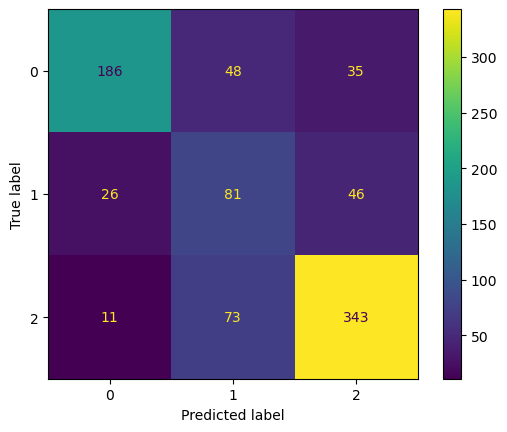

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Getting the indices for the categorical columns
cat_indices = [X.columns.get_loc(col) for col in categorical_columns]

# Creating the SMOTE objects
smote = SMOTENC(categorical_features = cat_indices, random_state = 1)

# Applying SMOTE to X and Y
X_resampled , Y_resampled = smote.fit_resample(X_train_transformed, Y_train)

logis_model = LogisticRegression()

grid = GridSearchCV(estimator=logis_model, param_grid=param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted')
grid.fit(X_resampled, Y_resampled)
print("Best weights: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)
print()

# Printing classification report to compare SMOTE vs no SMOTE
best_logis = grid.best_estimator_
Y_pred_logis_smote = best_logis.predict(X_test_transformed)

print(classification_report(Y_test, Y_pred_logis_smote))
print()

# Printing Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred_logis_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## SMOTE on Naive Bayes

In [4]:
# Getting the indices for the categorical columns
cat_indices = [X.columns.get_loc(col) for col in categorical_columns]

# Creating the SMOTE objects
smote = SMOTENC(categorical_features = cat_indices, random_state = 1)

# Applying SMOTE to X and Y
X_resampled , Y_resampled = smote.fit_resample(X_train_transformed, Y_train)

naive_bayes = GaussianNB()

naive_bayes.fit(X_resampled, Y_resampled)
Y_pred_naive_smote = naive_bayes.predict(X_test_transformed)

print(classification_report(Y_test, Y_pred_naive_smote))

              precision    recall  f1-score   support

     Dropout       0.68      0.52      0.59       269
    Enrolled       0.27      0.61      0.37       153
    Graduate       0.78      0.53      0.63       427

    accuracy                           0.54       849
   macro avg       0.57      0.56      0.53       849
weighted avg       0.65      0.54      0.57       849

